In [136]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
GS_FILE='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/magma_10kb_1000.60_traits.gs'
# FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/results/fig_hep'

df_gs = pd.read_csv(GS_FILE, sep='\t')
TRAIT_LIST_FULL = sorted(df_gs['TRAIT'])

# Data set info
DS_LIST = ['ts_facs']
DIC_INFO = {}
DIC_INFO['ts_facs'] = {'species': 'hsapiens', 'dname': 'TS FACS'}

# Set score files
DIC_SCORE_PATH = {'ts_facs': DATA_PATH+'/score_file/score.ts_facs_with_cov.magma_10kb_1000'}

In [138]:
# Load raw data 
dic_data_raw = {}
dic_data_raw['ts_facs'] = dl.load_ts_facs_raw_data()

dic_data_proc = {}
dic_data_proc['ts_facs'] = dic_data_raw['ts_facs'][dic_data_raw['ts_facs'].obs['tissue']=='Pancreas'].copy()

# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    print('# Loading %s score'%score)
    for trait in TRAIT_LIST_FULL:
        score_file = DIC_SCORE_PATH[score]+'/%s.score.gz'%trait
        if os.path.exists(score_file) is False:
            print('# Missing score file: %s'%trait)
        temp_df = pd.read_csv(score_file, sep='\t', index_col=0)
        temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
        temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
        dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)

# Align cell list 
dic_cell_list = {}
for ds in DS_LIST:
    dic_cell_list[ds] = list(set(dic_data_proc['ts_facs'].obs_names) & set(dic_score[ds].index))
display(dic_data_raw[ds][dic_cell_list[ds],:].obs.groupby('cell_ontology_class').agg({'Donor':len}))

# Loading ts_facs score


,Donor
cell_ontology_class,
b cell,88
endothelial cell,25
mast cell,50
myeloid cell,52
pancreatic acinar cell,512
pancreatic alpha cell,25
pancreatic beta cell,10
pancreatic ductal cell,68
pancreatic pp cell,68


In [139]:
# Overall association
TRAIT_LIST = []
for ds in DS_LIST:
    print('# %s'%DIC_INFO[ds]['dname'])
    for trait in TRAIT_LIST_FULL:
        if '%s.fdr'%trait not in dic_score[ds].columns:
            print('# Missing %s'%trait)
            continue
            
        ind_select = (dic_score[ds].loc[dic_cell_list[ds], '%s.fdr'%trait]<0.1)
        if ind_select.mean()>0.01:
            print('# %s %0.3f'%(trait, ind_select.mean()))
            temp_df = dic_data_proc[ds].obs.copy()
            temp_df = temp_df.join(dic_score[ds][['%s.fdr'%trait]])
            temp_df['sig'] = temp_df['%s.fdr'%trait]<0.1
            temp_df = temp_df.groupby('cell_ontology_class').agg({'sig':np.mean})
            temp_df = temp_df.loc[temp_df['sig']>0.1]
            if temp_df.shape[0]>0:
                display(temp_df)
            TRAIT_LIST.append(trait)

# TS FACS
# UKB_460K.biochemistry_Glucose 0.042


,sig
cell_ontology_class,
pancreatic alpha cell,0.200000
pancreatic beta cell,0.900000
pancreatic pp cell,0.338235


In [140]:
TRAIT_INFO_FILE=DATA_PATH+'/supp_table/trait_info.tsv'
DF_TRAIT_INFO = pd.read_csv(TRAIT_INFO_FILE, sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']

temp_df = dic_data_raw[ds].obs.groupby('cell_ontology_class').agg({'Donor':len})
celltype_list = list(temp_df.index[temp_df['Donor']>25])

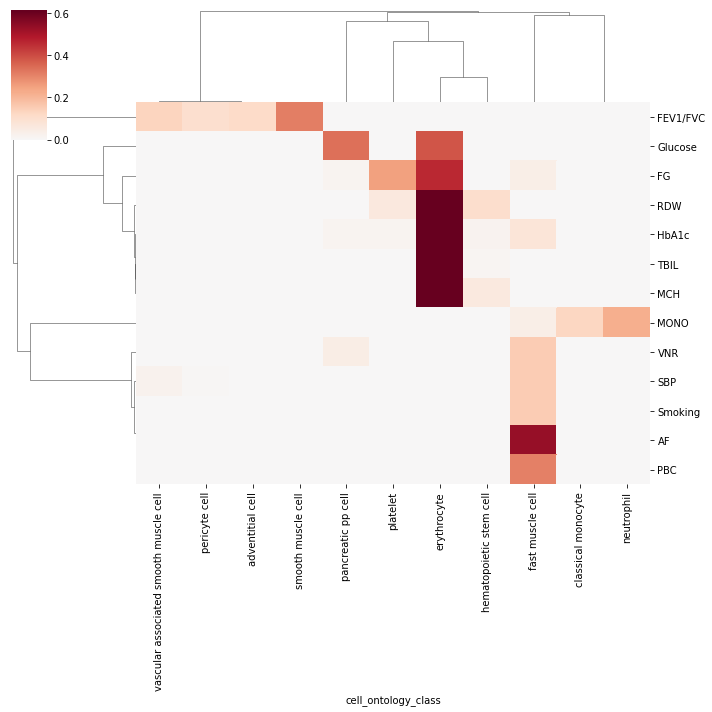

In [141]:
trait_list = [x.replace('.fdr','') for x in dic_score['ts_facs'].columns if '.fdr' in x]
fdr_list = [x for x in dic_score['ts_facs'].columns if '.fdr' in x]

temp_df = dic_data_raw['ts_facs'].obs.copy()
temp_df = temp_df.loc[temp_df['cell_ontology_class'].isin(celltype_list)].copy()
temp_df = temp_df.join(dic_score['ts_facs'][fdr_list])
temp_df = temp_df.loc[temp_df.isna().sum(axis=1)==0]
temp_df[fdr_list] = (temp_df[fdr_list]<0.1)*1
# temp_df = temp_df.loc[temp_df]

df_plot = temp_df.groupby('cell_ontology_class').agg({'%s.fdr'%x:np.mean for x in trait_list})
df_plot = df_plot.loc[(df_plot>0.1).sum(axis=1)>0].copy()
df_plot = df_plot.loc[:, (df_plot>0.1).sum(axis=0)>0].copy()
df_plot = df_plot.T
df_plot.index = [DF_TRAIT_INFO.loc[x.replace('.fdr',''), 'Code'] for x in df_plot.index]

sns.clustermap(df_plot, metric='cosine', cmap='RdBu_r', center=0)

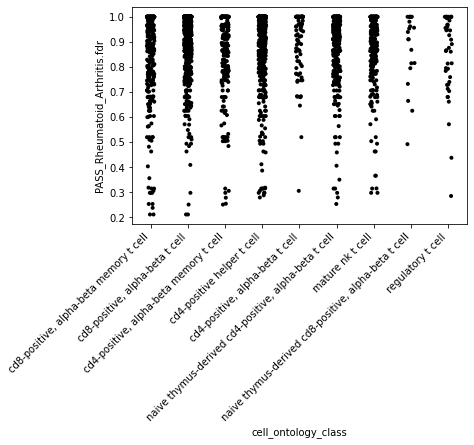

In [143]:
t_cell_list = [x for x in set(dic_data_raw['ts_facs'].obs['cell_ontology_class']) if ' t cell' in x]
trait = 'PASS_Rheumatoid_Arthritis'

df_plot = dic_data_raw['ts_facs'].obs.copy()
df_plot = df_plot.join(dic_score['ts_facs'][['%s.pval'%trait, '%s.fdr'%trait]])

plt.figure()
# sns.violinplot(data=df_plot, x='cell_ontology_class', y='%s.fdr'%trait, order=t_cell_list)
sns.stripplot(data=df_plot, x='cell_ontology_class', y='%s.fdr'%trait, order=t_cell_list, color='k', s=4)
plt.xticks(np.arange(len(t_cell_list)), t_cell_list, rotation=45, ha='right')
plt.show()

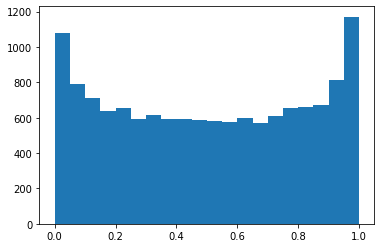

In [144]:
trait = 'PASS_Multiple_sclerosis'
plt.figure()
plt.hist(dic_score['ts_facs']['%s.pval'%trait], bins=20)
plt.show()

In [131]:
trait_list

['PASS_AtrialFibrillation_Nielsen2018',
 'PASS_BIP_Stahl2019',
 'PASS_CD_deLange2017',
 'PASS_Celiac',
 'PASS_Coronary_Artery_Disease',
 'PASS_FastingGlucose_Manning',
 'PASS_GeneralRiskTolerance_KarlssonLinner2019',
 'PASS_IBD_deLange2017',
 'PASS_Insomnia_Jansen2019',
 'PASS_Intelligence_SavageJansen2018',
 'PASS_MDD_Howard2019',
 'PASS_Multiple_sclerosis',
 'PASS_Primary_biliary_cirrhosis',
 'PASS_ReactionTime_Davies2018',
 'PASS_Rheumatoid_Arthritis',
 'PASS_SWB',
 'PASS_Schizophrenia_Ruderfer2018',
 'PASS_SleepDuration_Dashti2019',
 'PASS_Type_2_Diabetes',
 'PASS_UC_deLange2017',
 'PASS_VerbalNumericReasoning_Davies2018',
 'PASS_Worry_Nagel2018',
 'UKB_460K.biochemistry_AlanineAminotransferase',
 'UKB_460K.biochemistry_AlkalinePhosphatase',
 'UKB_460K.biochemistry_Cholesterol',
 'UKB_460K.biochemistry_Glucose',
 'UKB_460K.biochemistry_HDLcholesterol',
 'UKB_460K.biochemistry_HbA1c',
 'UKB_460K.biochemistry_LDLdirect',
 'UKB_460K.biochemistry_SHBG',
 'UKB_460K.biochemistry_Testoste